In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Divide the annotation file into multiple .txt files for each image
# Define the paths
annotation_path = "./grocery_annotations/annotation.txt"
image_dir = "./Images_Grocery/ShelfImages/"

# Open the annotation file
with open(annotation_path, 'r') as f:
    lines = f.readlines()

# Process each line
for line in lines:
    parts = line.split()
    image_name = parts[0]
    num_objects = int(parts[1])
    objects = [parts[i:i+5] for i in range(2, len(parts), 5)]

    # Create a new annotation file for this image
    with open(os.path.join(image_dir, image_name + '.txt'), 'w') as f:
        for obj in objects:
            # Write the object annotation to the file
            f.write(' '.join(obj) + '\n')

In [3]:
from sklearn.model_selection import train_test_split

def list_files(full_data_path = "./Images_Grocery/ShelfImages/", image_ext = '.JPG', test_size = 0.15, validation_size = 0.15):

    files = []

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(image_ext):
                files.append(file)

    # Split the data into training and testing
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

    # Split the training data into training and validation
    train_files, val_files = train_test_split(train_files, test_size=validation_size, random_state=42)

    return train_files, val_files, test_files

In [4]:
training_files, validation_files, test_files = list_files()

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

255 training files
45 validation files
54 test files


In [5]:
input_size = 244
new_size = (244, 244)  # New size (height, width)

def resize_image_and_box(img, box):
    # Calculate the scale factors
    y_scale = input_size / img.shape[0]
    x_scale = input_size / img.shape[1]

    # Resize the image
    resized_img = cv2.resize(img, new_size)

    x, y, w, h = box[0], box[1], box[2], box[3]
    #new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    # Scale the bounding box coordinates
    resized_box = [int(box[0] * x_scale), int(box[1] * y_scale), int(box[2] * x_scale), int(box[3] * y_scale)]

    return resized_img, resized_box

def format_image(img1, box1):
    img = img1.copy()
    box = box1.copy()
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv2.resize(img, new_size, interpolation= cv2.INTER_AREA)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int(x / r), int(y / r), int(w / r), int(h / r)]
    
    return new_image, new_box

In [6]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.dataset = self.create_dataset(images_folder)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        entry = self.dataset[idx]

        # If you want to apply any image transformations
        if self.transform:
            entry["image"] = self.transform(entry["image"])

        # Convert to PyTorch tensor
        image = transforms.ToTensor()(entry["image"])

        # Convert bounding boxes and class labels to tensors
        bounding_boxes = torch.tensor(entry["bounding_boxes"], dtype=torch.int64)
        class_labels = torch.tensor(entry["class_label"], dtype=torch.int64)

        # Create target dictionary
        target = {
            'boxes': bounding_boxes,
            'labels': class_labels
        }

        return image, target
    
    def create_dataset(self, files, full_data_path = "./Images_Grocery/ShelfImages/"):
        dataset = []
        
        for file in files:
            # Load the image in grayscale
            img = cv2.imread(os.path.join(full_data_path, file), cv2.IMREAD_GRAYSCALE)
            k = 1
            labels = []
            with open(os.path.join(full_data_path, file + ".txt"), 'r') as fp:
                lines = fp.readlines()
                boxes = []
                for line in lines:
                    parts = line.split()
                    box = np.array(parts[:4], dtype=int)
                    xmin = box[0]
                    ymin = box[1]
                    xmax = box[0] + box[2]
                    ymax = box[1] + box[3]
                    box[0] = xmin
                    box[1] = ymin
                    box[2] = xmax
                    box[3] = ymax
                    if(box[0] == 0):
                        box[0] = 0.1
                    copy_img, box = format_image(img, box)
                    #copy_img = copy_img.astype(int) / 255
                    boxes.append(box)
                    labels.append(k)
                    
                dataset.append({
                    "image": copy_img,
                    "bounding_boxes": boxes,
                    "class_label": labels
                })

        return dataset


#custom_dataset = CustomDataset(training_files)
#train_dataset = CustomDataset(training_files)
#val_dataset = CustomDataset(validation_files)
test_dataset = CustomDataset(test_files)

# Example: Using DataLoader
#train_loader = DataLoader(train_dataset, batch_size=31, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=1, shuffle=True,num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


imga name:  C4_P08_N3_S3_2.JPG


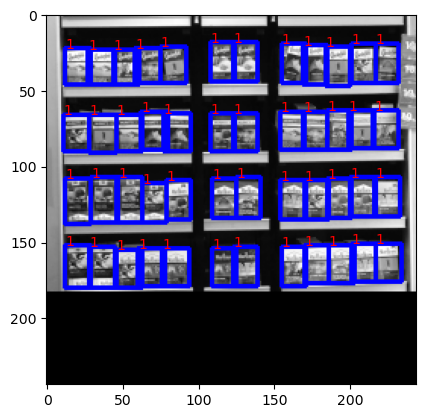

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get the first batch from the dataloader
first_batch = next(iter(test_loader))

# Get the first image, bounding boxes, and labels from the batch
images = first_batch[0]
targets = first_batch[1]
#class_labels = first_batch['class_label']

# Convert the image tensor to a numpy array and transpose the dimensions for matplotlib
image = images[0].squeeze(0).squeeze(0)

# Convert the image to float32
image = image.numpy().astype(np.float32)

# Convert the grayscale image to RGB
temp_color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Get the first bounding box and convert it to numpy
boxes = targets['boxes'][0].numpy()
labels = targets['labels'][0].numpy()
for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    cv2.rectangle(temp_color_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
    plt.text(xmin, ymin, str(label), color='red')
print( "imga name: " ,image_name)
plt.imshow(temp_color_img)
# for box, label in zip(boxes, labels):
#     x, y, w, h = int(box[0]),int(box[1]), int(box[2]), int(box[3])
#     cv2.rectangle(temp_color_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
#     plt.text(x, y, str(label), color='red')
# plt.imshow(temp_color_img)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class PredictionNet(nn.Module):
    def __init__(self, num_classes) -> None:
        super(PredictionNet, self).__init__()
        num_boxes = {"conv4_3": 4, "conv7": 6, "conv8_2": 6,
                     "conv9_2": 6, "conv10_2": 4, "conv11_2": 4}

        self.loc_layers = nn.ModuleList()
        self.cls_layers = nn.ModuleList()
        self.num_classes = num_classes
        in_channels = {"conv4_3": 512, "conv7": 1024, "conv8_2": 256, "conv9_2": 256, "conv10_2": 256, "conv11_2": 256}
        
        for feature_map in ["conv4_3", "conv7", "conv8_2", "conv9_2", "conv10_2", "conv11_2"]:
            loc_layer = nn.Conv2d(in_channels[feature_map], num_boxes[feature_map] * 4, kernel_size=(3, 3), padding=1)
            cls_layer = nn.Conv2d(in_channels[feature_map], num_boxes[feature_map] * num_classes, kernel_size=(3, 3), padding=1)

            self.loc_layers.append(loc_layer)
            self.cls_layers.append(cls_layer)
        self.weights_init()

    def forward(self, out_vgg, out_conv7, out_conv8, out_conv9, out_conv10, out_conv11):
        # Location predictions
        batch_size = out_vgg.size(0)
        locs_pred = []
        for i, conv_out in enumerate([out_vgg, out_conv7, out_conv8, out_conv9, out_conv10, out_conv11]):
            locs_pred.append(self.loc_layers[i](conv_out).permute(0, 2, 3, 1).contiguous().view(conv_out.size(0), -1, 4))
        
        locs_pred = torch.cat(locs_pred, dim=1)

        # Class predictions
        cls_pred = []
        for i, conv_out in enumerate([out_vgg, out_conv7, out_conv8, out_conv9, out_conv10, out_conv11]):
            cls_pred.append(self.cls_layers[i](conv_out).permute(0, 2, 3, 1).contiguous().view(conv_out.size(0), -1, self.num_classes))
        
        cls_pred = torch.cat(cls_pred, dim=1)

        return locs_pred, cls_pred

    
    def weights_init(self):
        for loc_layer, cls_layer in zip(self.loc_layers, self.cls_layers):
            nn.init.xavier_uniform_(loc_layer.weight)
            nn.init.zeros_(loc_layer.bias)
            nn.init.xavier_uniform_(cls_layer.weight)
            nn.init.zeros_(cls_layer.bias)


In [9]:
# def forward(self, out_vgg, out_conv7, out_conv8, out_conv9, out_conv10, out_conv11):
#         # Location predictions
#         batch_size = out_vgg.size(0)
#         l_conv4_3 = self.loc_layers[0](out_vgg)    #(N, 16, 38, 38)
#         l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()    #(N, 38, 38, 16)
#         l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)    #(N, 5776, 4)
#         assert l_conv4_3.size(1) == 5776
        
#         l_conv7 = self.loc_layers[1](out_conv7)    #(N, 24, 19, 19)
#         l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()    #(N, 19, 19, 24)
#         l_conv7 = l_conv7.view(batch_size, -1, 4)    #(N, 2166, 4)
#         assert l_conv7.size(1) == 2166
        
#         l_conv8_2 = self.loc_layers[2](out_conv8)    #(N, 24, 10, 10)
#         l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()    #(N, 10, 10, 24)
#         l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)    #(N, 600, 4)
#         assert l_conv8_2.size(1) == 600
        
#         l_conv9_2= self.loc_layers[3](out_conv9)    #(N, 24, 5, 5)
#         l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()    #(N, 5, 5, 24)
#         l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)    #(N, 150, 4)
#         assert l_conv9_2.size(1) == 150
        
#         l_conv10_2 = self.loc_layers[4](out_conv10)    #(N, 16, 3, 3)
#         l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()    #(N, 3, 3, 16)
#         l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)    #(N, 36, 4)
#         assert l_conv10_2.size(1) == 36
        
#         l_conv11_2 = self.loc_layers[5](out_conv11)    #(N, 16, 1, 1)
#         l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()    #(N, 1, 1, 16)
#         l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)    #(N, 4, 4)
#         assert l_conv11_2.size(1) == 4

#         #Predict class in loc boxes
#         c_conv4_3 = self.cls_layers[0](out_vgg)    #(N, 4*classes, 38, 38)
#         c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()    #(N, 38, 38, 4*classes)
#         c_conv4_3 = c_conv4_3.view(batch_size, -1, self.num_classes)    #(N, 5776, classes )
#         assert c_conv4_3.size(1) == 5776
        
#         c_conv7 = self.cls_layers[1](out_conv7)    #(N, 6*classes, 19, 19)
#         c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()    #(N, 19, 19, 6*classes)
#         c_conv7 = c_conv7.view(batch_size, -1, self.num_classes)   #(N, 2166, classes)
#         assert c_conv7.size(1) == 2166        
        
#         c_conv8_2 = self.cls_layers[2](out_conv8)    #(N, 6*clases, 10, 10)
#         c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()    #(N, 10, 10, 6*classes)
#         c_conv8_2 = c_conv8_2.view(batch_size, -1, self.num_classes)    #(N, 600, classes)
#         assert c_conv8_2.size(1) == 600
        
#         c_conv9_2 = self.cls_layers[3](out_conv9)    #(N, 6*classes, 5, 5)
#         c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()    #(N, 5, 5, 6*classes)
#         c_conv9_2 = c_conv9_2.view(batch_size, -1, self.num_classes)    #(N, 150, classes)
#         assert c_conv9_2.size(1) == 150
        
#         c_conv10_2 = self.cls_layers[4](out_conv10)    #(N, 4*classes, 3, 3)
#         c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()    #(N, 3, 3, 4*classes)
#         c_conv10_2 = c_conv10_2.view(batch_size, -1, self.num_classes)    #(N, 36, classes)
#         assert c_conv10_2.size(1) == 36
        
#         c_conv11 = self.cls_layers[5](out_conv11)    #(N, 4*classes, 1, 1)
#         c_conv11 = c_conv11.permute(0, 2, 3, 1).contiguous()    #(N, 1, 1, 4*classes)
#         c_conv11 = c_conv11.view(batch_size, -1, self.num_classes)    #(N, 4, classes)
#         assert c_conv11.size(1) == 4
        
#         locs_pred = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2,
#                                l_conv10_2, l_conv11_2], dim= 1)    #(N, 8732, 4)
#         assert locs_pred.size(0) == batch_size
#         assert locs_pred.size(1) == 8732
#         assert locs_pred.size(2) == 4
       
#         cls_pred = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2,
#                                c_conv10_2, c_conv11], dim=1)
#         assert cls_pred.size(0) == batch_size
#         assert cls_pred.size(1) == 8732
#         assert cls_pred.size(2) == self.num_classes

#         return locs_pred, cls_pred

In [10]:

class ConvNet (nn.Module):
    def __init__(self ) -> None:
        super(ConvNet,self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=(1, 1), padding= 0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size= (3, 3), padding= 1, stride= 2)
        
        self.conv9_1 = nn.Conv2d(512, 128, kernel_size= (1, 1), padding= 0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size= (3, 3), padding= 1, stride= 2)
        
        self.conv10_1 = nn.Conv2d(256, 128, kernel_size= (1, 1), padding= 0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size= (3, 3), padding= 0)
        
        self.conv11_1 = nn.Conv2d(256, 128, kernel_size= (1, 1), padding= 0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size= (3, 3), padding= 0) 
    def forward(self, conv7_out):
       
        x = conv7_out    #(N, 1024, 19, 19)
        x = F.relu(self.conv8_1(x))    #(N, 256, 19, 19)
        x = F.relu(self.conv8_2(x))    #(N, 512, 10, 10)
        conv8_2_out = x
        
        x = F.relu(self.conv9_1(x))    #(N, 128, 10, 10)
        x = F.relu(self.conv9_2(x))    #(N, 256, 5, 5)
        conv9_2_out = x
        
        x = F.relu(self.conv10_1(x))   #(N, 128, 5, 5)
        x = F.relu(self.conv10_2(x))   #(N, 256, 3, 3)
        conv10_2_out = x
        
        x = F.relu(self.conv11_1(x))   #(N, 128, 3, 3)
        conv11_2_out = F.relu(self.conv11_2(x))   #(N, 256, 1, 1)

        return conv8_2_out, conv9_2_out, conv10_2_out, conv11_2_out

In [20]:
import torchvision.models as models
class ModifiedVGG16(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ModifiedVGG16, self).__init__()
        
        
        vgg16 = models.vgg16(pretrained=pretrained)
        print(vgg16)
     
        self.features = vgg16.features
        
     
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
        
       
        vgg16.classifier[6] = nn.Linear(4096, 1024)
        
        self.load_state_dict(vgg16.state_dict(), strict=False)
          
        self.auxiliary_net = ConvNet()
        self.prediction_net = PredictionNet(num_classes=num_classes)

    

    def forward(self, x):
        x = self.features(x)
        outvgg=x 
        
        x = F.interpolate(x, size=(19, 19), mode='bilinear', align_corners=False)
        x = F.relu(self.conv6(x))
        x =F.relu( self.conv7(x))
        
      
        aux_out = self.auxiliary_net(x)
        print(len(aux_out))
        locs_pred, cls_pred = self.prediction_net.forward(outvgg, x, aux_out[0], aux_out[1], aux_out[2], aux_out[3])


        return aux_out, locs_pred, cls_pred


In [21]:

num_classes = 2  
ssd_model= ModifiedVGG16(num_classes=num_classes, pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Test
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=100, input_size=(3, 244, 244)):
        self.num_samples = num_samples
        self.input_size = input_size
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Skapa en slumpmässig bild med rätt indatastorlek (3, 300, 300)
        sample = torch.rand(self.input_size)
        return sample

# Create testdataset och dataloader
test_dataset = TestDataset()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssd_model.to(device)

# Testa model
ssd_model.eval()
for batch_idx, inputs in enumerate(test_loader):
    inputs = inputs.to(device)
    print(inputs.shape)  
    outputs = ssd_model(inputs)

  
    cls_pred = outputs[-1]

  
    print(f"Batch {batch_idx}, Output Shape: {cls_pred.shape}")

ssd_model.train()


torch.Size([1, 3, 244, 244])
4


RuntimeError: Given groups=1, weight of size [24, 256, 3, 3], expected input[1, 512, 10, 10] to have 256 channels, but got 512 channels instead

In [ ]:
import torch.optim as optim
# Ange optimerare och förlustfunktion
optimizer = optim.SGD(ssd_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Träna modellen
num_epochs = 10  # Ändra efter behov
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssd_model.to(device)

for epoch in range(num_epochs):
    ssd_model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = ssd_model(inputs)

        # Anta att cls_pred är ditt output för klassprediktionen
        cls_pred = outputs[-1]  # Justera detta beroende på hur dina output är organiserade

        loss = criterion(cls_pred, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")

    # Utvärdera på valideringsuppsättningen efter varje epoch
    ssd_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = ssd_model(inputs)
            cls_pred = outputs[-1]

            loss = criterion(cls_pred, targets)
            val_loss += loss.item()

            _, predicted = cls_pred.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    average_val_loss = val_loss / len(val_loader)
    accuracy = 100.0 * correct / total

    print(f"Epoch {epoch}, Validation Loss: {average_val_loss}, Accuracy: {accuracy}%")

NameError: name 'train_loader' is not defined